## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore", UserWarning)

vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 800
vbt.settings['plotting']['layout']['height'] = 400

sequence_length = 80  # Example: 20 timesteps per sequence
# Update these dimensions based on your dataset
input_dim = 11  # Number of features
hidden_dim = 32
num_layers = 2
output_dim = 3  # Number of classes

num_epochs = 150
learning_rate=0.05
step_size=20
gamma=0.8

print_epochs = 2

In [2]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad');


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_94699/3057766720.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_94699/3057766720.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad');


In [3]:
data = vbt.Data.from_data(df)

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

adx = vbt.ADX.run(high_price, low_price, close_price, window=14)
atr = vbt.ATR.run(high_price, low_price, close_price, window=14)
bbands = vbt.BBANDS.run(close_price, window=14)
rsi = vbt.RSI.run(close_price)
sma = vbt.MA.run(close_price, window=20)
strend = vbt.SUPERTREND.run(high_price, low_price, close_price, period=7, multiplier=3)

data.data['symbol']['ADX'] = adx.adx
data.data['symbol']['ATR'] = atr.atr
data.data['symbol']['BBAND'] = bbands.bandwidth
data.data['symbol']['RSI'] = rsi.rsi
data.data['symbol']['SMA'] = sma.ma
data.data['symbol']['STREND'] = strend.trend
data.data['symbol'] = data.data['symbol'].dropna()
predictor_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'ADX', 'ATR', 'BBAND', 'RSI', 'SMA', 'STREND']

X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']

In [4]:

test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



In [5]:
scl = StandardScaler()

X_train_scaled=scl.fit_transform(X_train)
X_train= X_train.assign(Open=X_train_scaled[:, 0])
X_train= X_train.assign(High=X_train_scaled[:, 1])
X_train= X_train.assign(Low=X_train_scaled[:, 2])
X_train= X_train.assign(Close=X_train_scaled[:, 3])
X_train= X_train.assign(Volume=X_train_scaled[:, 4])
X_train= X_train.assign(ADX=X_train_scaled[:, 5])
X_train= X_train.assign(ATR=X_train_scaled[:, 6])
X_train= X_train.assign(BBAND=X_train_scaled[:, 7])
X_train= X_train.assign(RSI=X_train_scaled[:, 8])
X_train= X_train.assign(SMA=X_train_scaled[:, 9])
X_train= X_train.assign(STREND=X_train_scaled[:, 10])


X_test_scaled=scl.transform(X_test)

X_test= X_test.assign(Open=X_test_scaled[:, 0])
X_test= X_test.assign(High=X_test_scaled[:, 1])
X_test= X_test.assign(Low=X_test_scaled[:, 2])
X_test= X_test.assign(Close=X_test_scaled[:, 3])
X_test= X_test.assign(Volume=X_test_scaled[:, 4])
X_test= X_test.assign(ADX=X_test_scaled[:, 5])
X_test= X_test.assign(ATR=X_test_scaled[:, 6])
X_test= X_test.assign(BBAND=X_test_scaled[:, 7])
X_test= X_test.assign(RSI=X_test_scaled[:, 8])
X_test= X_test.assign(SMA=X_test_scaled[:, 9])
X_test= X_test.assign(STREND=X_test_scaled[:, 10])

In [6]:
timestep = 80
X_train_list = []
y_train_list = []

# Adjust the range to stop at the last point where a full timestep can be created
for i in range(timestep, len(X_train) - timestep + 1):  # Adjust the loop to stop earlier
    X_train_list.append(np.array(X_train.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_train_list.append(y_train.iloc[i])  # Assuming you want the next value as the target

X_test_list = []
y_test_list = []

for i in range(timestep, len(X_test) - timestep + 1):  # Adjust the loop to stop earlier
    X_test_list.append(np.array(X_test.iloc[i-timestep:i]))
    # Only append the next value instead of a range of values
    y_test_list.append(y_test.iloc[i])  # Assuming you want the next value as the target

In [7]:
x_train = np.array(X_train_list)
x_test = np.array(X_test_list)  

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [10]:
# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to('cpu')  # device could be 'cpu' or 'cuda'

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Dropout layer
        # self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply dropout to the output of the LSTM
        # out = self.dropout(out)
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        return out



# Create the model
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Use CrossEntropyLoss for multi-class classification
# Initialize the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)




In [12]:
# class EarlyStopping:
#     def __init__(self, patience=7, verbose=False, delta=0):

#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = np.Inf
#         self.delta = delta

#     def __call__(self, val_loss):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss)
#             self.counter = 0

#     def save_checkpoint(self, val_loss):
#         '''Saves model when validation loss decrease.'''
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         self.val_loss_min = val_loss

In [13]:

# Assuming loss_fn is already defined as CrossEntropyLoss
# e.g., loss_fn = torch.nn.CrossEntropyLoss()
# For classification, it might be more informative to track accuracy or other metrics
# hist will track the loss for now
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_train_pred = model(x_train)

    # Compute loss
    loss = loss_fn(y_train_pred, y_train.long())  # Ensure y_train is of type torch.long
    if t % print_epochs == 0:  # Adjust logging frequency according to your preference
        print("Epoch ", t, "Loss: ", loss.item())
    hist[t] = loss.item()

    # Zero gradients before backward pass
    optimiser.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to all the learnable parameters
    loss.backward()

    # Update the parameters using the gradients and optimizer algorithm
    optimiser.step()
    
    # Step the scheduler
    scheduler.step()

    # Optional: Calculate and print accuracy or other metrics every few epochs
    # This is more meaningful for classification tasks
    if t % print_epochs == 0:  # Adjust as needed
        with torch.no_grad():  # No need to track gradients for validation
            y_pred_tags = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)
            correct_preds = (y_pred_tags == y_train).float().sum()
            accuracy = correct_preds / y_train.shape[0]
            print(f'Epoch {t} Accuracy: {accuracy.item() * 100:.2f}%')


Epoch  0 Loss:  1.104401707649231
Epoch 0 Accuracy: 3.31%
Epoch  2 Loss:  1.0822649002075195
Epoch 2 Accuracy: 11.66%
Epoch  4 Loss:  1.0289876461029053
Epoch 4 Accuracy: 13.51%
Epoch  6 Loss:  0.9287179708480835
Epoch 6 Accuracy: 15.03%
Epoch  8 Loss:  0.9041914939880371
Epoch 8 Accuracy: 25.62%
Epoch  10 Loss:  0.8465250134468079
Epoch 10 Accuracy: 29.42%
Epoch  12 Loss:  0.8205674886703491
Epoch 12 Accuracy: 17.84%
Epoch  14 Loss:  0.7854243516921997
Epoch 14 Accuracy: 24.64%
Epoch  16 Loss:  0.7622345685958862
Epoch 16 Accuracy: 34.74%
Epoch  18 Loss:  0.7483370900154114
Epoch 18 Accuracy: 34.29%
Epoch  20 Loss:  0.7335430979728699
Epoch 20 Accuracy: 37.09%
Epoch  22 Loss:  0.7171141505241394
Epoch 22 Accuracy: 28.37%
Epoch  24 Loss:  0.7053176164627075
Epoch 24 Accuracy: 29.83%
Epoch  26 Loss:  0.6921297907829285
Epoch 26 Accuracy: 33.66%
Epoch  28 Loss:  0.6802598834037781
Epoch 28 Accuracy: 32.23%
Epoch  30 Loss:  0.6697341203689575
Epoch 30 Accuracy: 32.56%
Epoch  32 Loss:  0.6

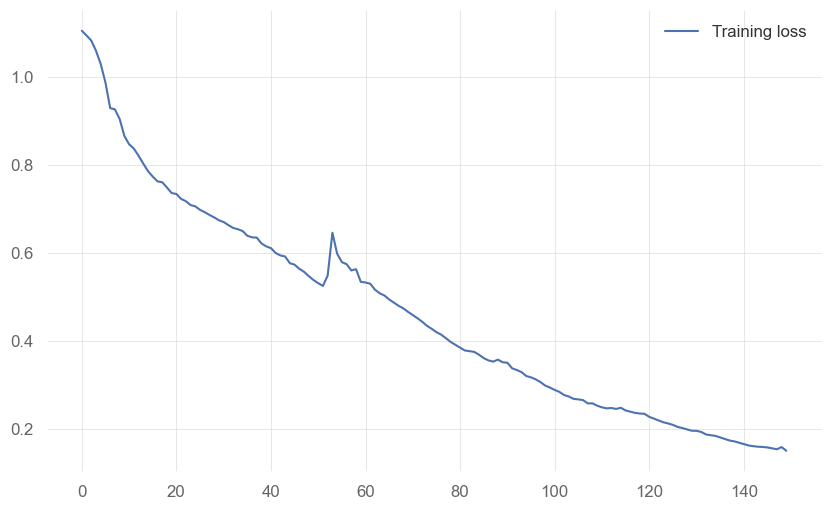

In [14]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [15]:
with torch.no_grad():
    
    y_test_pred = model(x_test)
    # Convert logits to probabilities
    probabilities = torch.softmax(y_test_pred, dim=1)

    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
predicted_labels_numpy = predicted_labels.numpy()
len(predicted_labels_numpy)


5082

In [16]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [17]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [18]:
pf.plot(settings=dict(bm_returns=False)).show()

In [19]:
pf.stats()

Start                         2023-06-02 13:00:00+00:00
End                           2023-12-31 06:00:00+00:00
Period                                211 days 18:00:00
Start Value                                  108.965502
Min Value                                     98.318673
Max Value                                    146.613042
End Value                                    122.809957
Total Return [%]                              12.705356
Benchmark Return [%]                         379.498581
Total Time Exposure [%]                       50.334514
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              32.940022
Max Drawdown Duration                 168 days 19:00:00
Total Orders                                        259
Total Fees Paid                                     0.0
Total Trades                                        130
Win Rate [%]                                  51.162791
Best Trade [%]                                15

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)

Precision: 0.36
Recall: 0.41
F1 Score: 0.36
Confusion Matrix:
 [[  40  124    3]
 [ 558 3813  389]
 [   1  124   30]]
